<a href="https://colab.research.google.com/github/multiopti/MYWAI/blob/main/rnn_implementation_gustavo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

We follow this post to implement an RNN  https://peterroelants.github.io/posts/rnn-implementation-part01/ to compare two binary strings of same length

In [41]:
# Imports
%matplotlib inline
%config InlineBackend.figure_formats = ['svg']

import itertools
import numpy as np  # Matrix and vector computation package
import matplotlib
import matplotlib.pyplot as plt  # Plotting library
import seaborn as sns  # Fancier plots

# Set seaborn plotting style
sns.set_style('darkgrid')
# Set the seed for reproducability
np.random.seed(seed=1)
#

The following code block initialises the dataset.

In [42]:
# Create dataset
nb_train = 2000  # Number of training samples
# Comparing 2 n-bit numbers 
sequence_len = 7  # Length of the binary sequence

def create_dataset(nb_samples, sequence_len):
    """Create a dataset and return as input, targets."""
    max_int = 2**(sequence_len) -1 # Maximum integer that can be added
     # Transform integer in binary format
    format_str = '{:0' + str(sequence_len) + 'b}'
    nb_inputs = 2   
    nb_outputs = 1  
    # Input samples
    X = np.zeros((nb_samples, sequence_len, nb_inputs))
    # Target samples
    T = np.zeros((nb_samples, sequence_len, nb_outputs))
    # Fill up the input and target matrix
    for i in range(nb_samples):
        # Generate random numbers to add
        nb1 = np.random.randint(0, max_int)
        nb2 = 31
        # Fill current input and target row.
        X[i,:,0] = list([int(b) for b in format_str.format(nb1)])
        X[i,:,1] = list([int(b) for b in format_str.format(nb2)])
        for n in range(sequence_len):
          if X[i,n,0] == X[i,n,1] :
            T[i,n,0] = 1
          else:
            T[i,n,0] = 0
    return X, T

# Create training samples
X_train, T_train = create_dataset(nb_train, sequence_len)
print(f'X_train tensor shape: {X_train.shape}')
print(f'T_train tensor shape: {T_train.shape}')
print(X_train[0,:,0])
print(X_train[0,:,1])
print(T_train[0,:,0])
#

X_train tensor shape: (2000, 7, 2)
T_train tensor shape: (2000, 7, 1)
[0. 1. 0. 0. 1. 0. 1.]
[0. 0. 1. 1. 1. 1. 1.]
[1. 0. 0. 0. 1. 0. 1.]


In [43]:
# Define the linear tensor transformation layer
class TensorLinear(object):
    """The linear tensor layer applies a linear tensor dot product 
    and a bias to its input."""
    def __init__(self, n_in, n_out, tensor_order, W=None, b=None):
        """Initialse the weight W and bias b parameters."""
        a = np.sqrt(6.0 / (n_in + n_out))
        self.W = (np.random.uniform(-a, a, (n_in, n_out)) 
                  if W is None else W)
        self.b = (np.zeros((n_out)) if b is None else b)
        # Axes summed over in backprop
        self.bpAxes = tuple(range(tensor_order-1))

    def forward(self, X):
        """Perform forward step transformation with the help 
        of a tensor product."""
        # Same as: Y[i,j,:] = np.dot(X[i,j,:], self.W) + self.b 
        #          (for i,j in X.shape[0:1])
        # Same as: Y = np.einsum('ijk,kl->ijl', X, self.W) + self.b
        return np.tensordot(X, self.W, axes=((-1),(0))) + self.b

    def backward(self, X, gY):
        """Return the gradient of the parmeters and the inputs of 
        this layer."""
        # Same as: gW = np.einsum('ijk,ijl->kl', X, gY)
        # Same as: gW += np.dot(X[:,j,:].T, gY[:,j,:]) 
        #          (for i,j in X.shape[0:1])
        gW = np.tensordot(X, gY, axes=(self.bpAxes, self.bpAxes))
        gB = np.sum(gY, axis=self.bpAxes)
        # Same as: gX = np.einsum('ijk,kl->ijl', gY, self.W.T)
        # Same as: gX[i,j,:] = np.dot(gY[i,j,:], self.W.T) 
        #          (for i,j in gY.shape[0:1])
        gX = np.tensordot(gY, self.W.T, axes=((-1),(0)))  
        return gX, gW, gB

In [44]:
# Define the logistic classifier layer
class LogisticClassifier(object):
    """The logistic layer applies the logistic function to its 
    inputs."""
   
    def forward(self, X):
        """Perform the forward step transformation."""
        return 1. / (1. + np.exp(-X))
    
    def backward(self, Y, T):
        """Return the gradient with respect to the loss function 
        at the inputs of this layer."""
        # Average by the number of samples and sequence length.
        return (Y - T) / (Y.shape[0] * Y.shape[1])
    
    def loss(self, Y, T):
        """Compute the loss at the output."""
        return -np.mean((T * np.log(Y)) + ((1-T) * np.log(1-Y)))

In [45]:
# Define tanh layer
class TanH(object):
    """TanH applies the tanh function to its inputs."""
    
    def forward(self, X):
        """Perform the forward step transformation."""
        return np.tanh(X) 
    
    def backward(self, Y, output_grad):
        """Return the gradient at the inputs of this layer."""
        gTanh = 1.0 - (Y**2)
        return (gTanh * output_grad)

In [46]:
# Define internal state update layer
class RecurrentStateUpdate(object):
    """Update a given state."""
    def __init__(self, nbStates, W, b):
        """Initialse the linear transformation and tanh transfer 
        function."""
        self.linear = TensorLinear(nbStates, nbStates, 2, W, b)
        self.tanh = TanH()

    def forward(self, Xk, Sk):
        """Return state k+1 from input and state k."""
        return self.tanh.forward(Xk + self.linear.forward(Sk))
    
    def backward(self, Sk0, Sk1, output_grad):
        """Return the gradient of the parmeters and the inputs of 
        this layer."""
        gZ = self.tanh.backward(Sk1, output_grad)
        gSk0, gW, gB = self.linear.backward(Sk0, gZ)
        return gZ, gSk0, gW, gB

In [47]:
# Define layer that unfolds the states over time
class RecurrentStateUnfold(object):
    """Unfold the recurrent states."""
    def __init__(self, nbStates, nbTimesteps):
        """Initialse the shared parameters, the inital state and 
        state update function."""
        a = np.sqrt(6. / (nbStates * 2))
        self.W = np.random.uniform(-a, a, (nbStates, nbStates))
        self.b = np.zeros((self.W.shape[0]))  # Shared bias
        self.S0 = np.zeros(nbStates)  # Initial state
        self.nbTimesteps = nbTimesteps  # Timesteps to unfold
        self.stateUpdate = RecurrentStateUpdate(
            nbStates, self.W, self.b)  # State update function
        
    def forward(self, X):
        """Iteratively apply forward step to all states."""
        # State tensor
        S = np.zeros((X.shape[0], X.shape[1]+1, self.W.shape[0]))
        S[:,0,:] = self.S0  # Set initial state
        for k in range(self.nbTimesteps):
            # Update the states iteratively
            S[:,k+1,:] = self.stateUpdate.forward(X[:,k,:], S[:,k,:])
        return S
    
    def backward(self, X, S, gY):
        """Return the gradient of the parmeters and the inputs of 
        this layer."""
        # Initialise gradient of state outputs
        gSk = np.zeros_like(gY[:,self.nbTimesteps-1,:])
        # Initialse gradient tensor for state inputs
        gZ = np.zeros_like(X)
        gWSum = np.zeros_like(self.W)  # Initialise weight gradients
        gBSum = np.zeros_like(self.b)  # Initialse bias gradients
        # Propagate the gradients iteratively
        for k in range(self.nbTimesteps-1, -1, -1):
            # Gradient at state output is gradient from previous state 
            #  plus gradient from output
            gSk += gY[:,k,:]
            # Propgate the gradient back through one state
            gZ[:,k,:], gSk, gW, gB = self.stateUpdate.backward(
                S[:,k,:], S[:,k+1,:], gSk)
            gWSum += gW  # Update total weight gradient
            gBSum += gB  # Update total bias gradient
        # Get gradient of initial state over all samples
        gS0 = np.sum(gSk, axis=0)
        return gZ, gWSum, gBSum, gS0

In [48]:
# Define the full network
class RnnBinaryDetecter(object):
    """RNN to compare two binary numbers"""
    def __init__(self, nb_of_inputs, nb_of_outputs, nb_of_states, 
                 sequence_len):
        """Initialse the network layers."""
        # Input layer
        self.tensorInput = TensorLinear(nb_of_inputs, nb_of_states, 3)
        # Recurrent layer
        self.rnnUnfold = RecurrentStateUnfold(nb_of_states, sequence_len)
        # Linear output transform
        self.tensorOutput = TensorLinear(nb_of_states, nb_of_outputs, 3)
        self.classifier = LogisticClassifier()  # Classification output
        
    def forward(self, X):
        """Perform the forward propagation of input X through all 
        layers."""
        # Linear input transformation
        recIn = self.tensorInput.forward(X)
        # Forward propagate through time and return states
        S = self.rnnUnfold.forward(recIn)
        # Linear output transformation
        Z = self.tensorOutput.forward(S[:,1:sequence_len+1,:])
        Y = self.classifier.forward(Z)  # Classification probabilities
        # Return: input to recurrent layer, states, input to classifier, 
        #  output
        return recIn, S, Z, Y
    
    def backward(self, X, Y, recIn, S, T):
        """Perform the backward propagation through all layers.
        Input: input samples, network output, intput to recurrent 
        layer, states, targets."""
        gZ = self.classifier.backward(Y, T)  # Get output gradient
        gRecOut, gWout, gBout = self.tensorOutput.backward(
            S[:,1:sequence_len+1,:], gZ)
        # Propagate gradient backwards through time
        gRnnIn, gWrec, gBrec, gS0 = self.rnnUnfold.backward(
            recIn, S, gRecOut)
        gX, gWin, gBin = self.tensorInput.backward(X, gRnnIn)
        # Return the parameter gradients of: linear output weights, 
        #  linear output bias, recursive weights, recursive bias, #
        #  linear input weights, linear input bias, initial state.
        return gWout, gBout, gWrec, gBrec, gWin, gBin, gS0
    
    def getOutput(self, X):
        """Get the output probabilities of input X."""
        recIn, S, Z, Y = self.forward(X)
        return Y
    
    def getBinaryOutput(self, X):
        """Get the binary output of input X."""
        return np.around(self.getOutput(X))
    
    def getParamGrads(self, X, T):
        """Return the gradients with respect to input X and 
        target T as a list. The list has the same order as the 
        get_params_iter iterator."""
        recIn, S, Z, Y = self.forward(X)
        gWout, gBout, gWrec, gBrec, gWin, gBin, gS0 = self.backward(
            X, Y, recIn, S, T)
        return [g for g in itertools.chain(
                np.nditer(gS0),
                np.nditer(gWin),
                np.nditer(gBin),
                np.nditer(gWrec),
                np.nditer(gBrec),
                np.nditer(gWout),
                np.nditer(gBout))]
    
    def loss(self, Y, T):
        """Return the loss of input X w.r.t. targets T."""
        return self.classifier.loss(Y, T)
    
    def get_params_iter(self):
        """Return an iterator over the parameters.
        The iterator has the same order as get_params_grad.
        The elements returned by the iterator are editable in-place."""
        return itertools.chain(
            np.nditer(self.rnnUnfold.S0, op_flags=['readwrite']),
            np.nditer(self.tensorInput.W, op_flags=['readwrite']),
            np.nditer(self.tensorInput.b, op_flags=['readwrite']),
            np.nditer(self.rnnUnfold.W, op_flags=['readwrite']),
            np.nditer(self.rnnUnfold.b, op_flags=['readwrite']),
            np.nditer(self.tensorOutput.W, op_flags=['readwrite']), 
            np.nditer(self.tensorOutput.b, op_flags=['readwrite']))

In [49]:
# Set hyper-parameters
lmbd = 0.5  # Rmsprop lambda
learning_rate = 0.05  # Learning rate
momentum_term = 0.80  # Momentum term
eps = 1e-6  # Numerical stability term to prevent division by zero
mb_size = 100  # Size of the minibatches (number of samples)

# Create the network
nb_of_states = 3  # Number of states in the recurrent layer
RNN = RnnBinaryDetecter(2, 1, nb_of_states, sequence_len)
# Set the initial parameters
# Number of parameters in the network
nbParameters =  sum(1 for _ in RNN.get_params_iter())
# Rmsprop moving average
maSquare = [0.0 for _ in range(nbParameters)]
Vs = [0.0 for _ in range(nbParameters)]  # Momentum

# Create a list of minibatch losses to be plotted
ls_of_loss = [
    RNN.loss(RNN.getOutput(X_train[0:100,:,:]), T_train[0:100,:,:])]
# Iterate over some iterations
for i in range(5):
    # Iterate over all the minibatches
    for mb in range(nb_train // mb_size):
        X_mb = X_train[mb:mb+mb_size,:,:]  # Input minibatch
        T_mb = T_train[mb:mb+mb_size,:,:]  # Target minibatch
        V_tmp = [v * momentum_term for v in Vs]
        # Update each parameters according to previous gradient
        for pIdx, P in enumerate(RNN.get_params_iter()):
            P += V_tmp[pIdx]
        # Get gradients after following old velocity
        # Get the parameter gradients
        backprop_grads = RNN.getParamGrads(X_mb, T_mb)    
        # Update each parameter seperately
        for pIdx, P in enumerate(RNN.get_params_iter()):
            # Update the Rmsprop moving averages
            maSquare[pIdx] = lmbd * maSquare[pIdx] + (
                1-lmbd) * backprop_grads[pIdx]**2
            # Calculate the Rmsprop normalised gradient
            pGradNorm = ((
                learning_rate * backprop_grads[pIdx]) / np.sqrt(
                maSquare[pIdx]) + eps)
            # Update the momentum
            Vs[pIdx] = V_tmp[pIdx] - pGradNorm     
            P -= pGradNorm   # Update the parameter
        # Add loss to list to plot
        ls_of_loss.append(RNN.loss(RNN.getOutput(X_mb), T_mb))

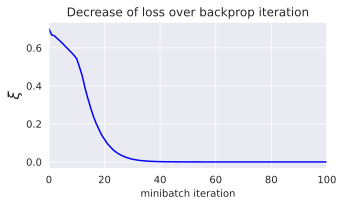

In [50]:
# Plot the loss over the iterations
fig = plt.figure(figsize=(5, 3))
plt.plot(ls_of_loss, 'b-')
plt.xlabel('minibatch iteration')
plt.ylabel('$\\xi$', fontsize=15)
plt.title('Decrease of loss over backprop iteration')
plt.xlim(0, 100)
fig.subplots_adjust(bottom=0.2)
plt.show()
#

In [51]:
# Create test samples
nb_test = 5
Xtest, Ttest = create_dataset(nb_test, sequence_len)
# Push test data through network
Y = RNN.getBinaryOutput(Xtest)
Yf = RNN.getOutput(Xtest)

# Print out all test examples
for i in range(Xtest.shape[0]):
    print(Xtest[i,:,0])
    print(Xtest[i,:,1])
    print(Y[i,:,0])
    print('')
#

[0. 1. 0. 0. 0. 1. 1.]
[0. 0. 1. 1. 1. 1. 1.]
[1. 0. 0. 0. 0. 1. 1.]

[0. 1. 1. 1. 0. 0. 1.]
[0. 0. 1. 1. 1. 1. 1.]
[1. 0. 1. 1. 0. 0. 1.]

[0. 0. 1. 1. 1. 1. 1.]
[0. 0. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1.]

[1. 1. 1. 1. 0. 1. 0.]
[0. 0. 1. 1. 1. 1. 1.]
[0. 0. 1. 1. 0. 1. 0.]

[0. 1. 0. 0. 1. 1. 1.]
[0. 0. 1. 1. 1. 1. 1.]
[1. 0. 0. 0. 1. 1. 1.]

